In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data( )

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
y_train.shape

(60000,)

In [0]:
x_train.shape

(60000, 28, 28)

In [0]:
y_train[0]

5

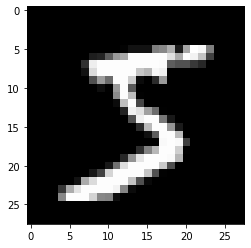

In [0]:
imagendemo=x_train[0]
plt.imshow(imagendemo,cmap='gray')

In [0]:
onehot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_train_onehot = onehot_encoder.fit_transform(y_train)

y_test = y_test.reshape(len(y_test), 1)
y_test_onehot = onehot_encoder.fit_transform(y_test)

y_train_onehot.shape

(60000, 10)

In [0]:
def conv2d(x, W,name,padd,strid=[1,1,1,1]):
    #El stride de esa función no reduce el tamaño de la imagen
    return tf.nn.conv2d(x, W, strides=strid, padding=padd,name=name)

def maxpool2d(x,ks,st):
    #           El st de esta función reduce la imagen a la mitad
    return tf.nn.max_pool(x, ksize=ks, strides=st, padding='SAME')

# Declarando la arquitectura


In [0]:
class DNN_model(object):
  def __init__(self,
               n_classes=10):
    self.h1LW = tf.Variable(np.random.rand(5,5,1,32),name="hl1weigths",dtype="float32")
    self.h1LB = tf.Variable(np.random.rand(32),name="hl1bias",dtype="float32")
    self.h2LW = tf.Variable(np.random.rand(5,5,32,64),name="hl2weigths",dtype="float32")
    self.h2LB = tf.Variable(np.random.rand(64),name="hl2bias",dtype="float32")
    self.h3LW = tf.Variable(np.random.rand(7*7*64,1024),name="hl3weigths",dtype="float32")
    self.h3LB = tf.Variable(np.random.rand(1024),name="hl3bias",dtype="float32")
    self.outW = tf.Variable(np.random.rand(1024, n_classes),name="outweigths",dtype="float32")
    self.outB = tf.Variable(np.random.rand(n_classes),name="outbias",dtype="float32")
    self.trainable_variables =[self.h1LW,self.h1LB,self.h2LW,self.h2LB,self.h3LW,self.h3LB,self.outW,self.outB]          
  def __call__(self,x): 

      # Declarando la arquitectura
      x  = tf.cast(x, tf.float32)
      img = tf.reshape(x, shape=[-1, 28, 28, 1])

      l1= tf.nn.conv2d(img,self.h1LW, strides=[1,1,1,1], padding='SAME')  
      l1 = tf.add(l1, self.h1LB)
      l1 = tf.nn.relu(l1)
      l1 = tf.nn.max_pool(l1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
      #14*14*32

      l2= tf.nn.conv2d(l1,self.h2LW, strides=[1,1,1,1], padding='SAME')  
      l2 = tf.add(l2, self.h2LB)
      l2 = tf.nn.relu(l2)
      l2 = tf.nn.max_pool(l2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
      #7*7*64
      
      l3=  tf.reshape(l2,[-1, 7*7*64])
      l3=  tf.matmul(l3,self.h3LW)
      l3 = tf.add(l3, self.h3LB)
      l3 = tf.nn.relu(l3)


      output = tf.matmul(l3,self.outW) + self.outB
      return output
  

In [0]:
DNN = DNN_model()
DNN(x_train[24:30])

<tf.Tensor: shape=(6, 10), dtype=float32, numpy=
array([[1.80498989e+11, 1.87543323e+11, 1.83942103e+11, 1.83275553e+11,
        1.80573209e+11, 1.86865713e+11, 1.84264098e+11, 1.88407939e+11,
        1.81671674e+11, 1.82872375e+11],
       [3.17994828e+11, 3.30414555e+11, 3.24103864e+11, 3.22879586e+11,
        3.18142022e+11, 3.29238053e+11, 3.24627202e+11, 3.31914379e+11,
        3.20076481e+11, 3.22217017e+11],
       [1.17215969e+11, 1.21776210e+11, 1.19435821e+11, 1.19031103e+11,
        1.17258650e+11, 1.21352684e+11, 1.19657529e+11, 1.22345095e+11,
        1.17969715e+11, 1.18752412e+11],
       [3.53298186e+11, 3.67085224e+11, 3.60091353e+11, 3.58733545e+11,
        3.53486766e+11, 3.65794623e+11, 3.60652505e+11, 3.68768713e+11,
        3.55624518e+11, 3.57997019e+11],
       [3.24444488e+11, 3.37125310e+11, 3.30719166e+11, 3.29463824e+11,
        3.24661117e+11, 3.35941403e+11, 3.31252367e+11, 3.38679628e+11,
        3.26626836e+11, 3.28773009e+11],
       [1.40318589e+11, 1.

In [0]:
optimizador = tf.compat.v1.train.AdamOptimizer(learning_rate=0.01)

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [0]:
@tf.function
def train_step(model,tdata, labels):
  with tf.GradientTape() as tape:
    predictions = model(tdata)
    #calculo de una funcion de error 
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))
   
  gradients = tape.gradient(loss, model.trainable_variables)
  capped_grads_and_vars = [(grad,model.trainable_variables[index]) for index, grad in enumerate(gradients)]
  optimizador.apply_gradients(capped_grads_and_vars)
  train_loss(loss)
  train_accuracy(labels, predictions)

In [0]:
@tf.function
def test_step(model,tdata, labels):
  predictions = model(tdata)
  t_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [0]:
def fitting(model,train_x,train_y,test_x,test_y,EPOCHS,N_batch,batch_size):
  for epoch in range(EPOCHS):
    i=0
    while i+batch_size < len(train_x) or i+batch_size<batch_size*N_batch:
      start = i
      end = i+batch_size
      batch_x = train_x[start:end]
      batch_y = train_y[start:end]
      train_step(model,batch_x,batch_y)
      i+=batch_size

    test_step(model,test_x,test_y)
      
    template = 'Epoch {}, Perdida: {}, Exactitud: {}, Perdida de prueba: {}, Exactitud de prueba: {}'
    print(template.format(epoch+1,
                         train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

  

In [0]:
fitting(DNN,x_train,y_train_onehot,x_test,y_test_onehot,20,600,100)

Epoch 1, Perdida: 249763744.0, Exactitud: 60.98163604736328, Perdida de prueba: 942306.125, Exactitud de prueba: 70.99000549316406
Epoch 2, Perdida: 533196.6875, Exactitud: 75.6193618774414, Perdida de prueba: 347530.75, Exactitud de prueba: 76.58000183105469
Epoch 3, Perdida: 165175.09375, Exactitud: 82.72286987304688, Perdida de prueba: 120477.1484375, Exactitud de prueba: 81.95999908447266
Epoch 4, Perdida: 57666.6640625, Exactitud: 87.45909881591797, Perdida de prueba: 28072.97265625, Exactitud de prueba: 90.63999938964844
Epoch 5, Perdida: 21820.048828125, Exactitud: 90.76961517333984, Perdida de prueba: 14359.955078125, Exactitud de prueba: 91.68999481201172
Epoch 6, Perdida: 10627.173828125, Exactitud: 92.44407653808594, Perdida de prueba: 8998.6591796875, Exactitud de prueba: 92.1199951171875
Epoch 7, Perdida: 6194.916015625, Exactitud: 93.47077941894531, Perdida de prueba: 4008.3408203125, Exactitud de prueba: 94.8499984741211
Epoch 8, Perdida: 3636.732421875, Exactitud: 94.52